# EXPLORATORY DATA ANALYSIS (I.)

In [3]:
import pandas as pd
import numpy as np

## Data preparation

In [4]:
financial_ratios_table = pd.read_csv('../../DATA/MODEL/financial_ratios_df.csv')

In [5]:
display(financial_ratios_table)

,entity_id,year,financial_report_id,financial_statement_id,financial_report_order_number,entity_ico,month,period_length,consolidated,type,...,RU_konkurz_2y_off,RU_ostatne_konania,RU_ostatne_konania_1y_off,RU_ostatne_konania_2y_off,RUZ_indirect_criterion,RUZ_indirect_criterion_1y_off,RUZ_indirect_criterion_2y_off,sknace_division_name,sknace_division,sknace_subcategory
0,4,2014,4644773,2382229,1,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,0.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
1,4,2015,5382540,2968194,1,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
2,4,2016,5665728,3194585,3,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
3,4,2017,6245237,3662172,2,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,1,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
4,4,2018,6757564,4072051,3,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,1,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331206,2048850,2021,8065588,5127715,1,54227623.0,12,1,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,NaN,NaN,"Administratívne, pomocné kancelárske a iné obc...",N,82.0
2331207,2049673,2021,8234552,5270688,1,54073618.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,NaN,NaN,"Administratívne, pomocné kancelárske a iné obc...",N,82.0
2331208,2051583,2021,7988745,5062309,1,54305233.0,12,1,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,NaN,NaN,Činnosti v oblasti nehnuteľností,L,68.0
2331209,2052305,2021,7976902,5052440,1,54167787.0,12,1,NaN,Riadna,...,0.0,0.0,0.0,0.0,1,1.0,1.0,"Ostatné odborné, vedecké a technické činnosti",M,74.0


In [6]:
column = 'SAL'

pivot = pd.pivot_table(financial_ratios_table.query('year <= 2019'), index = 'entity_ico', columns='year', values=column)
bool_wide = (pivot == pivot)
bool_wide['count'] = bool_wide.apply(sum, axis = 1)
bool_wide['count'].value_counts()

bool_wide.reset_index(inplace=True)
bool_wide.columns

Index(['entity_ico', 2014, 2015, 2016, 2017, 2018, 2019, 'count'], dtype='object', name='year')

In [7]:
bool_wide.columns = ['entity_ico', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'count']

In [8]:
entity_ico_list = list(bool_wide.query('count > 2 and y16 and y17')['entity_ico'].unique())

financial_ratios_table.query('entity_ico in @entity_ico_list', inplace= True)
financial_ratios_table

,entity_id,year,financial_report_id,financial_statement_id,financial_report_order_number,entity_ico,month,period_length,consolidated,type,...,RU_konkurz_2y_off,RU_ostatne_konania,RU_ostatne_konania_1y_off,RU_ostatne_konania_2y_off,RUZ_indirect_criterion,RUZ_indirect_criterion_1y_off,RUZ_indirect_criterion_2y_off,sknace_division_name,sknace_division,sknace_subcategory
0,4,2014,4644773,2382229,1,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,0.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
1,4,2015,5382540,2968194,1,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
2,4,2016,5665728,3194585,3,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
3,4,2017,6245237,3662172,2,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,1,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
4,4,2018,6757564,4072051,3,603783.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,1,1.0,1.0,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106540,1702449,2017,6292134,3697238,1,50316796.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,0.0,Činnosti súvisiace s údržbou zariadení a kraji...,N,81.0
2106541,1702449,2018,6470876,3835097,1,50316796.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,0.0,Činnosti súvisiace s údržbou zariadení a kraji...,N,81.0
2106542,1702449,2019,6950172,4221592,1,50316796.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,0.0,Činnosti súvisiace s údržbou zariadení a kraji...,N,81.0
2106543,1702449,2020,7411279,4591365,1,50316796.0,1,12,NaN,Riadna,...,0.0,0.0,0.0,0.0,0,0.0,NaN,Činnosti súvisiace s údržbou zariadení a kraji...,N,81.0


## Overall look on Population

In [27]:
def one_year_stats(df, i1, i2, yr):
    query_string = f'{i1} == 1 and {i2} == 1'
    val  = df.query(query_string)['entity_ico'].nunique()

    if val > 0:
        print(f'> {i1} + {i2}:', df.query(query_string)['entity_ico'].nunique())
        return set(df.query(query_string)['entity_ico'].unique())

    return set()

In [32]:

INDICATORS = ['RUZ_cancelled_1y_off', 'RU_konkurz_1y_off', 'RU_ostatne_konania_1y_off', 'DPHZ_vat_registration_cancelled_1y_off', 'RUZ_indirect_criterion_1y_off']

issues_model = dict()

for year in 2016, 2017, 2018, 2019, 2020:
    print(year)
    issues_model[year] = set()

    subset =  financial_ratios_table.query('year == @year and SAL > 0')
    print('ico count:', subset['entity_ico'].nunique())
    
    for i1 in INDICATORS:
        for i2 in INDICATORS:
            if i1 >= i2:
                continue

            issues_model[year] = issues_model[year].union(one_year_stats(subset, i1, i2, year))

    
    print(f'year {year}: {len(issues_model[year])}')
    print()

2016
ico count: 153508
> RUZ_cancelled_1y_off + RU_konkurz_1y_off: 1
> RUZ_cancelled_1y_off + RUZ_indirect_criterion_1y_off: 188
> RU_konkurz_1y_off + RU_ostatne_konania_1y_off: 4
> DPHZ_vat_registration_cancelled_1y_off + RU_ostatne_konania_1y_off: 1
> DPHZ_vat_registration_cancelled_1y_off + RUZ_indirect_criterion_1y_off: 78
> RUZ_indirect_criterion_1y_off + RU_konkurz_1y_off: 115
> RUZ_indirect_criterion_1y_off + RU_ostatne_konania_1y_off: 38
year 2016: 413

2017
ico count: 154844
> RUZ_cancelled_1y_off + RU_konkurz_1y_off: 9
> RUZ_cancelled_1y_off + RUZ_indirect_criterion_1y_off: 183
> RU_konkurz_1y_off + RU_ostatne_konania_1y_off: 7
> DPHZ_vat_registration_cancelled_1y_off + RU_konkurz_1y_off: 2
> DPHZ_vat_registration_cancelled_1y_off + RU_ostatne_konania_1y_off: 1
> DPHZ_vat_registration_cancelled_1y_off + RUZ_indirect_criterion_1y_off: 105
> RUZ_indirect_criterion_1y_off + RU_konkurz_1y_off: 154
> RUZ_indirect_criterion_1y_off + RU_ostatne_konania_1y_off: 13
year 2017: 440

201

In [16]:
import matplotlib.pyplot as plt

In [17]:
financial_ratios_table.columns

Index(['entity_id', 'year', 'financial_report_id', 'financial_statement_id',
       'financial_report_order_number', 'entity_ico', 'month', 'period_length',
       'consolidated', 'type', 'entity_name', 'establishment_date',
       'sknace_code', 'entity_state', 'CA', 'CASH', 'CL', 'EQ', 'NCL', 'TA',
       'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN', 'EAT', 'EBIT', 'SAL',
       'COST', 'INT', 'YIE', 'L3', 'L2', 'L1', 'CF_CL', 'CASH_TA', 'SAL_TA',
       'TL_SAL', 'INV_COST', 'INV_SAL', 'CC_SAL', 'TA_SAL', 'TL_TA', 'CF_TL',
       'CL_TA', 'NCL_TA', 'EQ_TL', 'EQ_TA', 'EBIT_INT', 'CL_CC', 'ROE',
       'EAT_TA', 'ROA_BRUTTO', 'CF_TA', 'CF_SAL', 'ROS', 'EAT_YIE', 'ROI',
       'ROA_NETTO', 'DPHZ_vat_registration_cancelled',
       'DPHZ_vat_registration_cancelled_1y_off',
       'DPHZ_vat_registration_cancelled_2y_off', 'RO_cancelled',
       'RO_cancelled_1y_off', 'RO_cancelled_2y_off', 'RUZ_cancelled',
       'RUZ_cancelled_1y_off', 'RUZ_cancelled_2y_off', 'RUZ_established',
       'R

In [21]:
predictors = ['L3', 'L2', 'L1', 'CF_CL', 'CASH_TA',
       'SAL_TA', 'TL_SAL', 'INV_COST', 'INV_SAL', 'CC_SAL', 'TA_SAL', 'TL_TA',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EQ_TL', 'EQ_TA', 'EBIT_INT', 'CL_CC',
       'ROE', 'EAT_TA', 'ROA_BRUTTO', 'CF_TA', 'CF_SAL', 'ROS', 'EAT_YIE',
       'ROI', 'ROA_NETTO']

print(len(predictors))

28


In [26]:
def remove_outliers_iqr(data):
    # Calculate the first and third quartiles
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    cleaned_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]
    
    return cleaned_data

In [23]:
def plot_histograms(df, columns):
    # Plotting the histograms
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df[column]
        
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        cleaned_data = data[~((data < lower_bound) | (data > upper_bound))]

        bin_width = 2 * IQR / (len(cleaned_data) ** (1/3))

        num_bins = int(np.ceil((np.max(cleaned_data) - np.min(cleaned_data)) / bin_width))

        ax.hist(cleaned_data, bins=num_bins, color='skyblue', edgecolor='black')
        ax.set_title(column)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

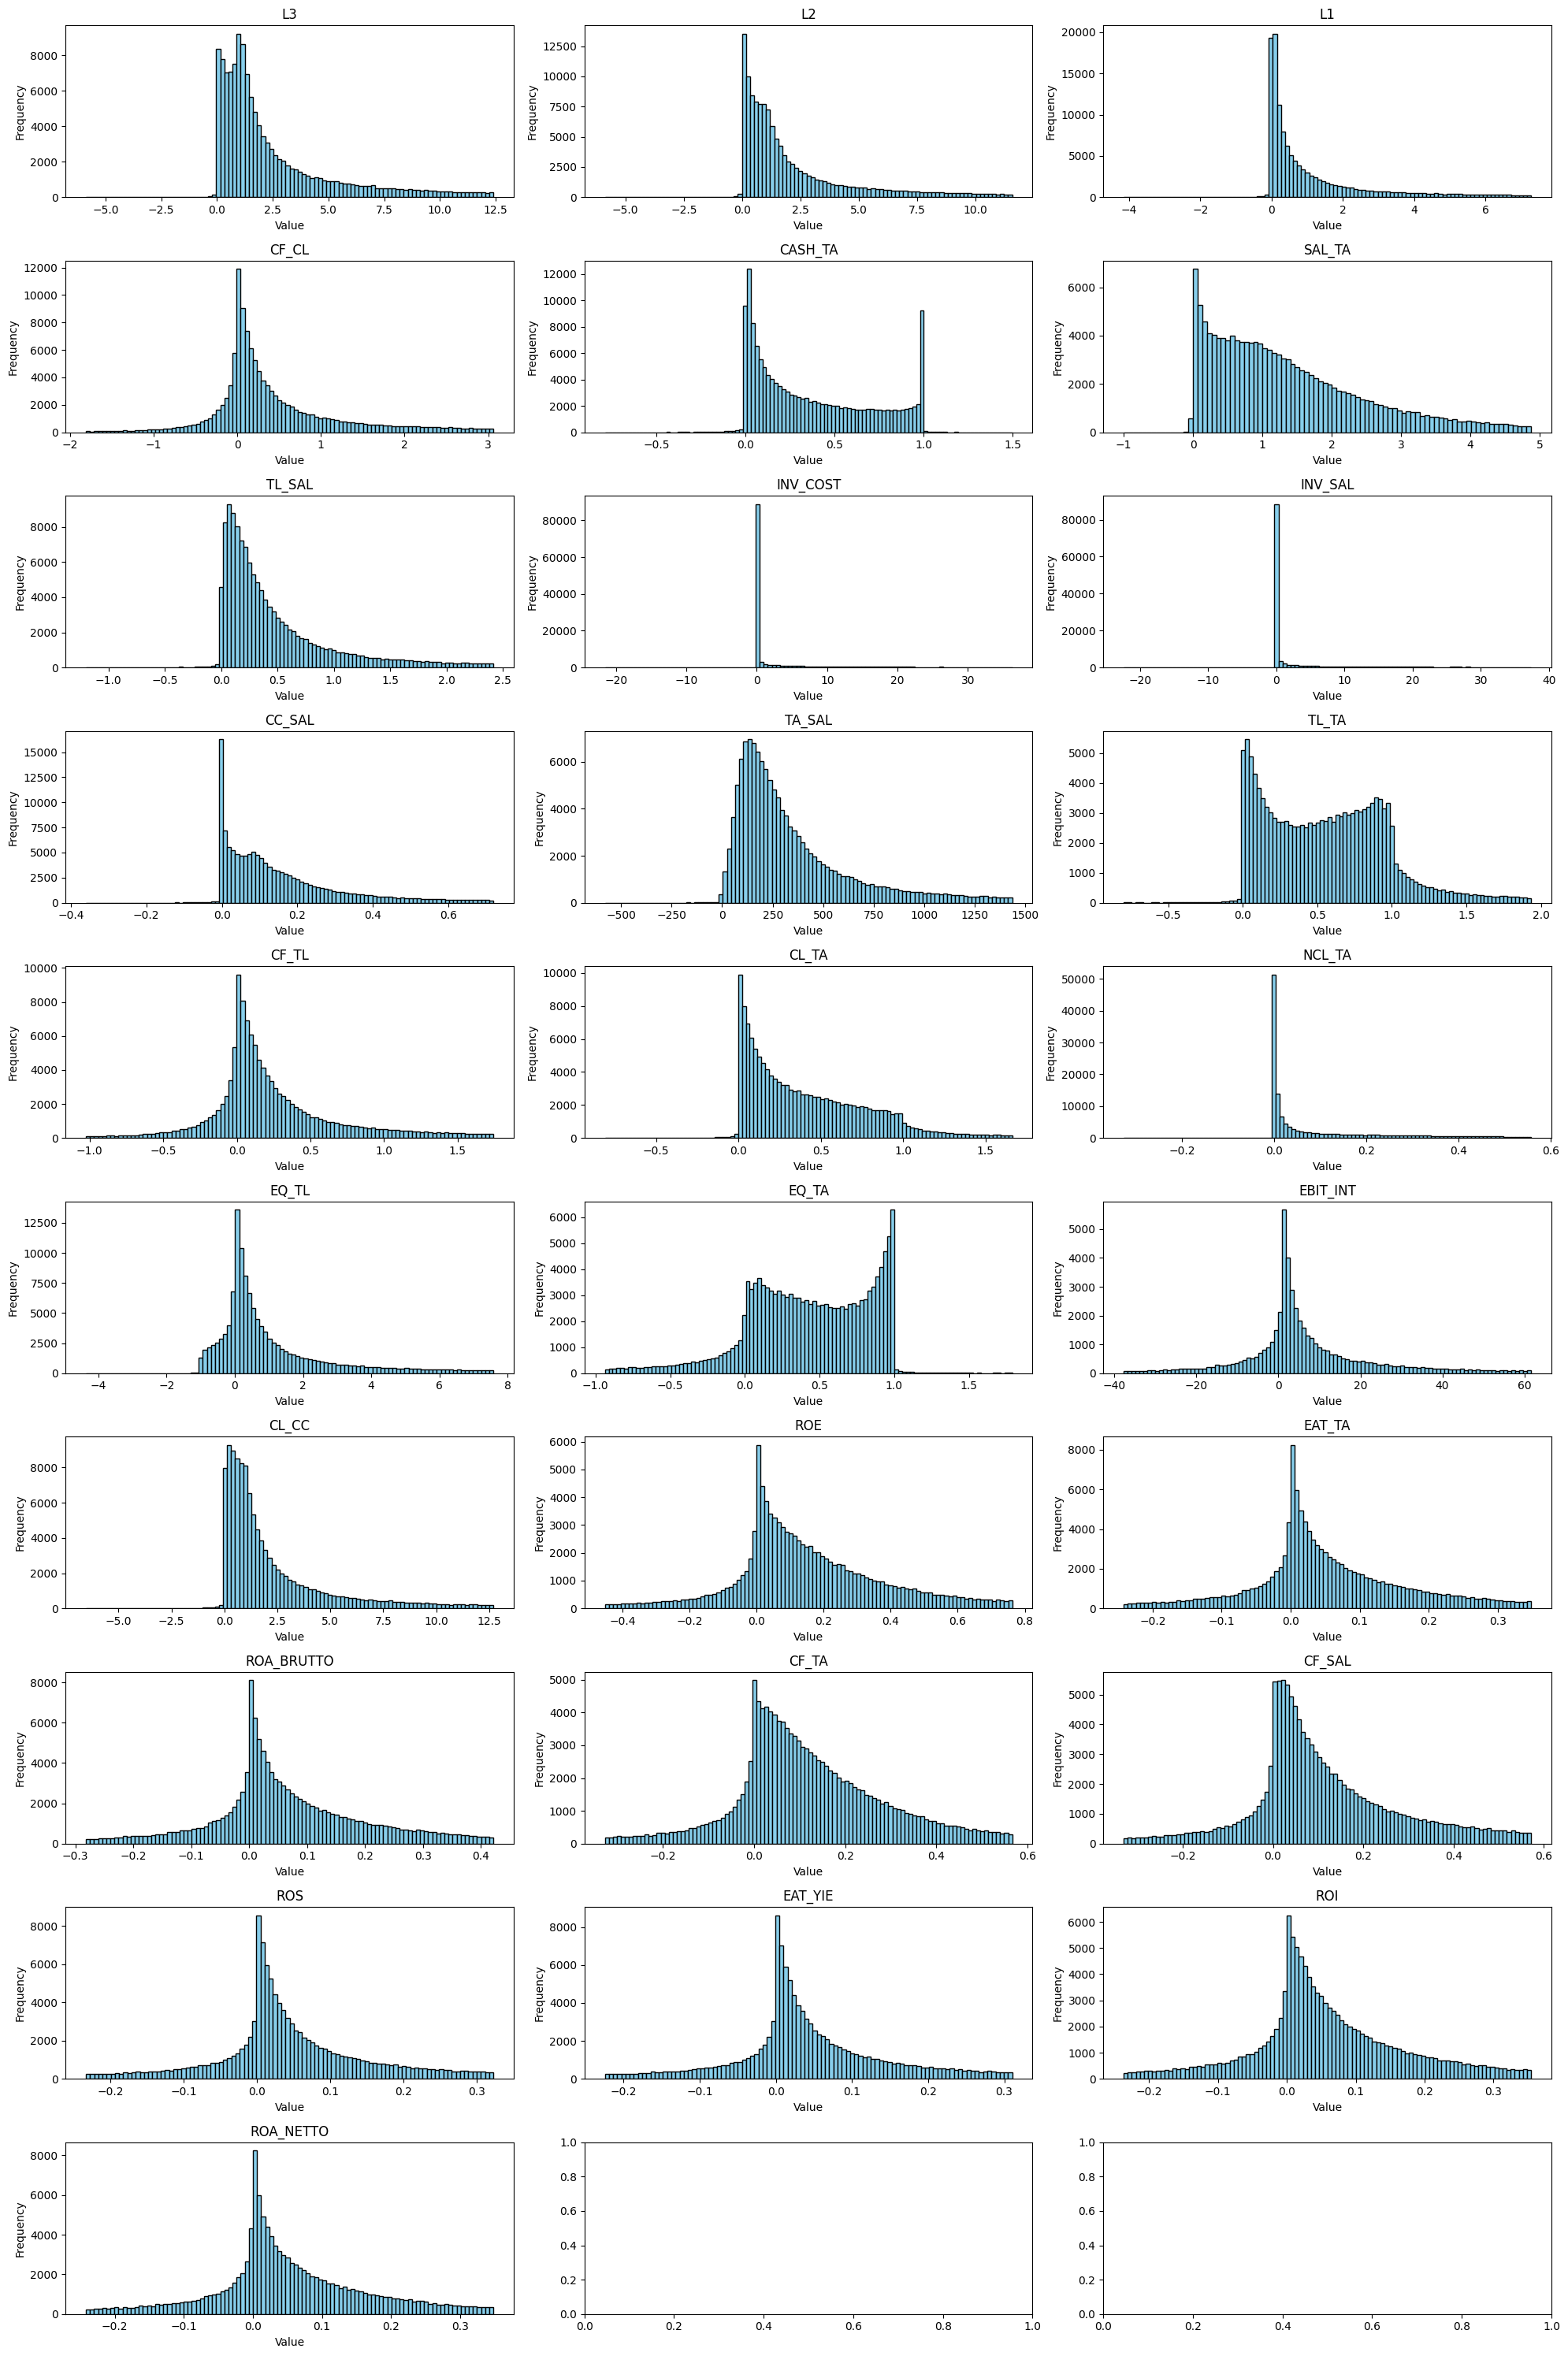

In [24]:
plot_histograms(merged_df.query('year == 2018 and period_length == 12 and SAL != 0'), predictors)

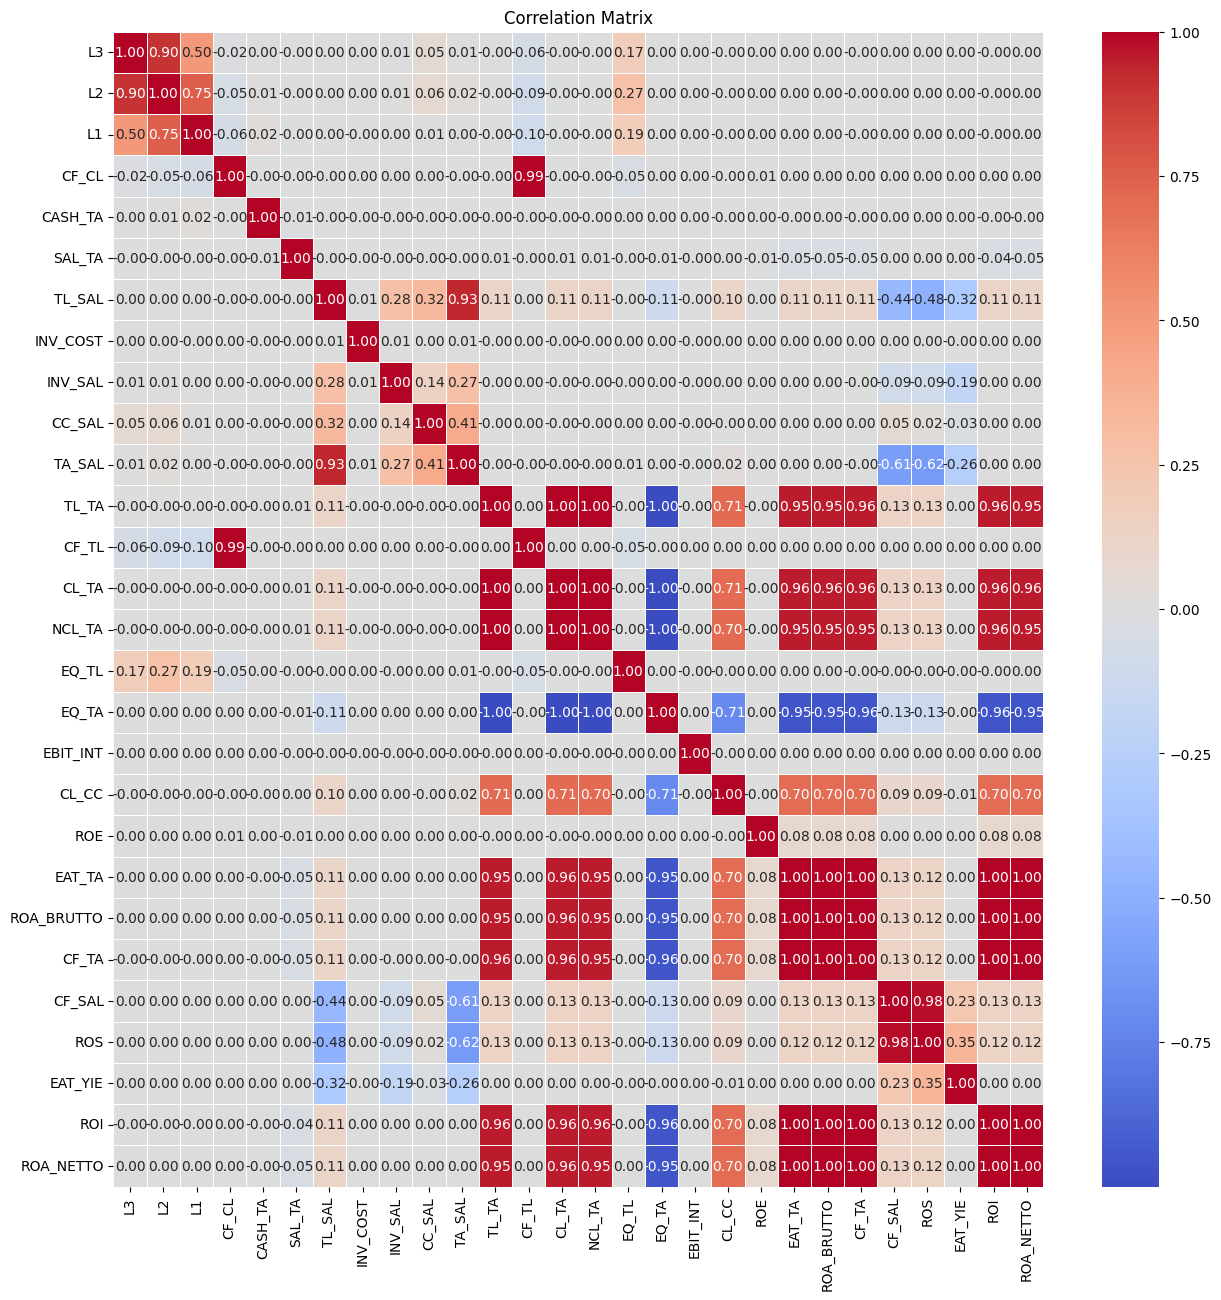

In [25]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = merged_df.query('year == 2018 and period_length == 12 and SAL != 0')[predictors].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()